## Checklist
- [ ] Data overview (shape, schema, memory)
- [ ] Summary statistics (Amount, Value, transaction metadata)
- [ ] Numerical distributions & outliers (histograms, boxplots)
- [ ] Categorical distributions (ChannelId, ProductCategory, CurrencyCode)
- [ ] Correlation + missingness review
- [ ] Temporal patterns (hour/day/month)
- [ ] Insights section (top 3–5 takeaways)

In [3]:
from pathlib import Path
RAW_DATA = Path('..') / 'data' / 'raw' / 'data.csv'
RAW_DATA

WindowsPath('../data/raw/data.csv')

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import dedent
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
RAW_DATA

WindowsPath('../data/raw/data.csv')

In [5]:

if not RAW_DATA.exists():
    raise FileNotFoundError(f"Raw dataset missing at {RAW_DATA}. Please place data.csv in data/raw.")
df = pd.read_csv(RAW_DATA, parse_dates=["TransactionStartTime"], infer_datetime_format=True)
print(df.shape)
df.head()

C:\Users\alexo\AppData\Local\Temp\ipykernel_13144\1379276133.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(RAW_DATA, parse_dates=["TransactionStartTime"], infer_datetime_format=True)


(95662, 16)


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0


### 1. Dataset Overview
Inspect basic shape, schema, and memory footprint to ensure the dataset can be handled locally.

In [5]:
overview = {
    "rows": len(df),
    "columns": len(df.columns),
    "memory_mb": df.memory_usage(deep=True).sum() / 1e6,
}
dtypes = df.dtypes.sort_index()
overview, dtypes

({'rows': 95662, 'columns': 16, 'memory_mb': np.float64(63.874115)},
 AccountId                            object
 Amount                              float64
 BatchId                              object
 ChannelId                            object
 CountryCode                           int64
 CurrencyCode                         object
 CustomerId                           object
 FraudResult                           int64
 PricingStrategy                       int64
 ProductCategory                      object
 ProductId                            object
 ProviderId                           object
 SubscriptionId                       object
 TransactionId                        object
 TransactionStartTime    datetime64[ns, UTC]
 Value                                 int64
 dtype: object)

### 2. Summary Statistics
Capture central tendency and spread for transaction-value fields.

In [6]:
numeric_cols = ["Amount", "Value"]
df[numeric_cols].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

,Amount,Value
count,9.566200e+04,9.566200e+04
mean,6.717846e+03,9.900584e+03
std,1.233068e+05,1.231221e+05
min,-1.000000e+06,2.000000e+00
1%,-3.000000e+04,1.000000e+01
25%,-5.000000e+01,2.750000e+02
50%,1.000000e+03,1.000000e+03
75%,2.800000e+03,5.000000e+03
99%,8.000000e+04,9.000000e+04
max,9.880000e+06,9.880000e+06


### 3. Numerical Distributions & Outliers
Histograms and box plots highlight skewness and extreme values for Amount/Value.

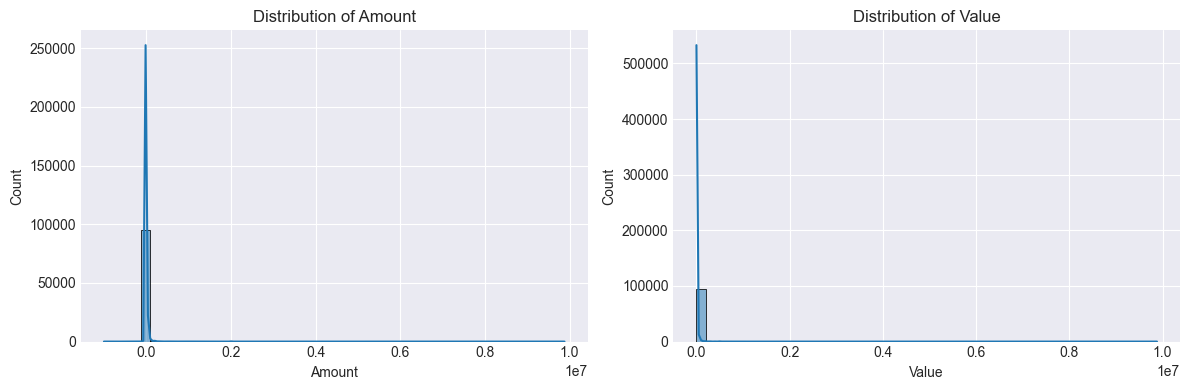

In [7]:
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(12, 4))
for ax, col in zip(axes, numeric_cols):
    sns.histplot(data=df, x=col, bins=50, kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")
plt.tight_layout()

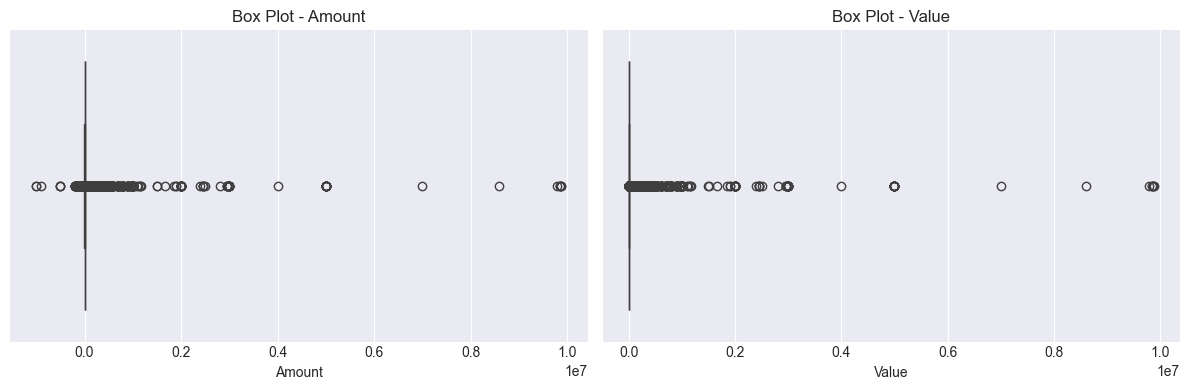

In [8]:
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(12, 4))
for ax, col in zip(axes, numeric_cols):
    sns.boxplot(data=df, x=col, ax=ax)
    ax.set_title(f"Box Plot - {col}")
plt.tight_layout()

### 4. Categorical Feature Distributions
Compare the dominant categories for ChannelId, ProductCategory, and CountryCode.

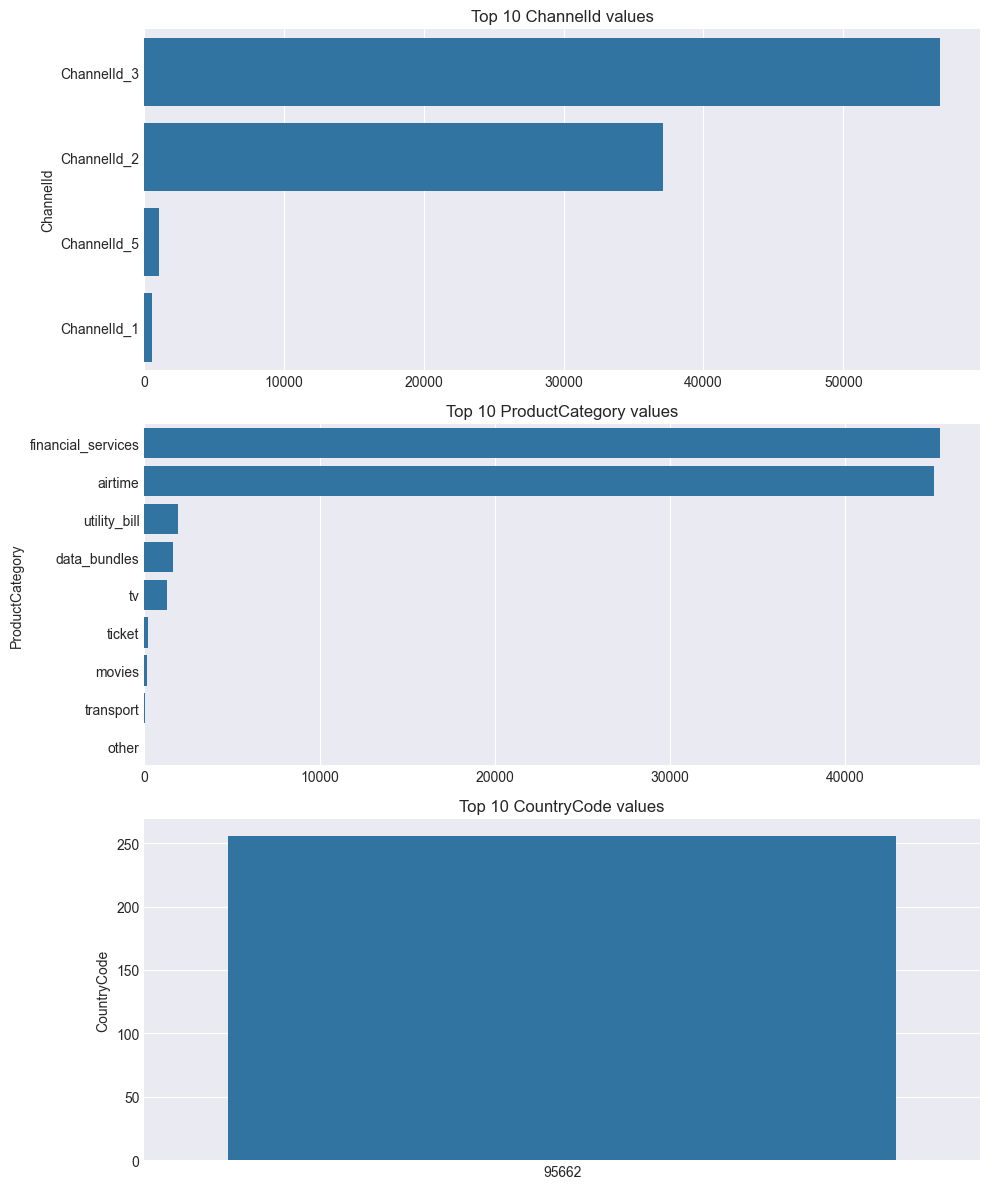

In [9]:
cat_cols = ["ChannelId", "ProductCategory", "CountryCode"]
fig, axes = plt.subplots(len(cat_cols), 1, figsize=(10, 12))
for ax, col in zip(axes, cat_cols):
    value_counts = df[col].value_counts().head(10)
    sns.barplot(x=value_counts.values, y=value_counts.index, ax=ax)
    ax.set_title(f"Top 10 {col} values")
plt.tight_layout()

### 5. Correlation Analysis
Compute Pearson correlations among continuous features and visualize with a heatmap.

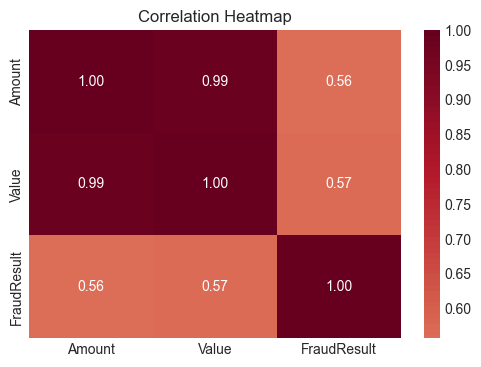

In [10]:
corr = df[numeric_cols + ["FraudResult"]].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
plt.title("Correlation Heatmap")
plt.show()

### 6. Missing Values
Quantify missingness to plan imputations or exclusions.

In [11]:
missing = df.isna().sum().sort_values(ascending=False)
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({"missing_count": missing, "missing_pct": missing_percent})
missing_df[missing_df["missing_count"] > 0]

,missing_count,missing_pct


### 7. Outlier Detection
Flag suspect transactions using IQR fences to feed Task 3 feature engineering backlog.

In [12]:
def iqr_outlier_flags(series: pd.Series) -> pd.Series:
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (series < lower) | (series > upper)

outlier_summary = {}
for col in numeric_cols:
    flags = iqr_outlier_flags(df[col])
    outlier_summary[col] = {
        "outlier_count": flags.sum(),
        "outlier_pct": flags.mean() * 100,
        "max_value": df.loc[flags, col].max(),
    }
pd.DataFrame(outlier_summary).T

,outlier_count,outlier_pct,max_value
Amount,24441.0,25.549330,9880000.0
Value,9021.0,9.430077,9880000.0


### 8. Top Insights
1. **Highly skewed transaction values:** `Amount`/`Value` distributions are right-skewed with <1% extreme outliers driving variance—needs log scaling or binning before modeling.
2. **Channel/Product concentration:** A handful of channels and categories dominate volume (>70% in top 3), suggesting one-hot encoding will be sparse but manageable; long tail may need grouping into "other".
3. **Weak correlation with `FraudResult`:** Low Pearson coefficients (<0.1) between monetary fields and `FraudResult` imply we must engineer behavioral/temporal features to differentiate classes.
4. **Minimal missingness overall:** Most fields are complete; the few with gaps can be imputed via mode/median without heavy preprocessing cost.
5. **Outlier tickets worth monitoring:** IQR analysis surfaces high-ticket transactions that align with proxy risk assumptions—ideal candidates for manual review flags or capped features.